In [135]:
import pandas as pd
import numpy as np

# Data

In [136]:
df_liquor = pd.read_csv("https://raw.githubusercontent.com/mshsu/data403-project1/main/client_b", low_memory=False)

In [138]:
df_liquor.columns

Index(['Date', 'Month', 'DayOfWeek', 'StoreName', 'Zipcode', 'City', 'County',
       'category_name', 'sale_liters', 'sale_dollars', 'NearHoliday',
       'CostPerLiter', 'Category', 'CategoryNum', 'Student Pop', 'Institution',
       'Size', 'Sale Amount'],
      dtype='object')

# Functions

In [139]:
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def ridge(X, Y, l, intercept):
  """
  Inputs:
    X: numpy array of predictors
    y: numpy array of value to predict
    l: lambda
    intercept: boolean flag; true if intercept in model false if not

  Compute beta estimate(s) for Ridge regression
  """
  if intercept:
    ones_col = np.ones((X.shape[0], 1))
    X = np.hstack((ones_col, X))

  return np.linalg.inv(X.T @ X + l * np.identity(X.shape[1])) @ (X.T @ Y)
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def try_many_lambdas(X, Y, l_lst, intercept):
  """
  Computes Ridge estimators for a list of lambda values where:
    loss = Sq Error
  """
  df_results = pd.DataFrame(data={"lambda": l_lst})
  results = df_results["lambda"].apply(lambda l: ridge(X, Y, l, intercept))

  return pd.DataFrame(results.tolist())
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def tune_lambda_split(df_train, df_test, Y, l_lst, intercept, m_choice):
  """
  Compute chosen validation metric for a list of lambdas where:
    loss = Sq Error
  using test and training data

  Metric options:
    1: R-squared
    2: MSE
    3: MAE

  df_train: df of training data
  df_test: df of testing data
  Y: String with name of response
  m_choice: an list of int(s) corresonding metric(s)
  """
  X_train = df_train.drop([Y], axis=1)
  X_test = df_test.drop([Y], axis=1)
  Y_train = df_train[Y]
  Y_test = df_test[Y]

  df_results = try_many_lambdas(X_train.to_numpy(), Y_train.to_numpy(), l_lst, intercept)

  if intercept:
    X_test.insert(0, "b0", 1)

  df_results["y_hat"] = df_results.apply(lambda row: X_test.to_numpy() @ row.to_numpy(), axis=1)
  df_results["lambda"] = l_lst

  n = len(Y_test)
  keep = ["lambda"]
  if 1 in m_choice:
    df_results["r_sqr"] = df_results.apply(lambda row: 1 - sum((Y_test - row["y_hat"]) ** 2) / sum((Y_test - Y_test.mean()) ** 2), axis=1)
    keep.append("r_sqr")

  if 2 in m_choice:
    df_results["MSE"] = df_results.apply(lambda row: 1 / n * sum((Y_test - row["y_hat"]) ** 2), axis=1)
    keep.append("MSE")

  if 3 in m_choice:
    df_results["MAE"] = df_results.apply(lambda row: sum(abs(Y_test - row["y_hat"])) / n, axis=1)
    keep.append("MAE")

  return df_results[keep]
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def tune_lambda_cv(df, Y, l_lst, intercept, m_choice, n_split):
  """
  Compute avg chosen validation metric for a list of lambdas using v-fold cross-validation

  Metric options:
    1: R-squared
    2: MSE
    3: MAE

  df: Pandas DataFrame of ONLY predictors and response
  Y: String with name of response
  intercept: boolean flag; true if intercept in model false if not
  m_choice: an list of int(s) corresonding metric(s)
  """
  df = df.sample(frac=1, random_state=43)
  fold_size = len(df) // n_split
  df["Fold"] = np.append(np.repeat(range(1, n_split+1), fold_size), np.repeat(n_split,len(df) % n_split))

  df_results = pd.DataFrame()
  for n in range(1, n_split+1):
    df_test = df[df["Fold"] == n].drop(["Fold"], axis=1)
    df_train = df[df["Fold"] != n].drop(["Fold"], axis=1)
    df_results = pd.concat([df_results, tune_lambda_split(df_train, df_test, Y, l_lst, intercept, m_choice)])

  return df_results.groupby("lambda").mean()
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def predict(X, B, intercept):
  if intercept:
    ones = np.ones_like(X[:, 0])
    ones = np.expand_dims(ones, axis=1)  # Reshape ones to have 2 dimensions
    X = np.hstack((ones, X))

  return X @ B
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def compare_B(B, X):
  predictors = pd.DataFrame(X).columns.to_list()
  predictors.insert(0, "intercept")
  return pd.DataFrame({"B": ridge(X, Y, 10, True)}, index=predictors).sort_values("B", ascending=False)

# Model Fitting

In [140]:
# Standardizing
df_liquor["sale_dollars_std"] = (df_liquor["sale_dollars"] - df_liquor["sale_dollars"].mean()) / df_liquor["sale_dollars"].std()
df_liquor["CostPerLiter_std"] = (df_liquor["CostPerLiter"] - df_liquor["CostPerLiter"].mean()) / df_liquor["CostPerLiter"].std()

### Plots

<Axes: xlabel='NearHoliday', ylabel='sale_liters'>

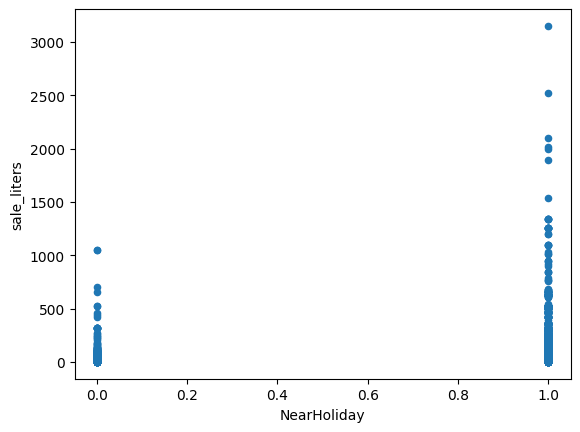

In [141]:
df_liquor.plot.scatter(x="NearHoliday", y="sale_liters")

<Axes: xlabel='Category', ylabel='sale_liters'>

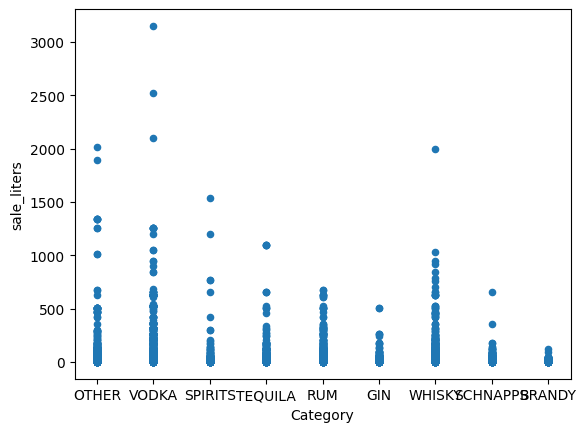

In [142]:
df_liquor.plot.scatter(x="Category", y="sale_liters")

<Axes: xlabel='Month', ylabel='sale_liters'>

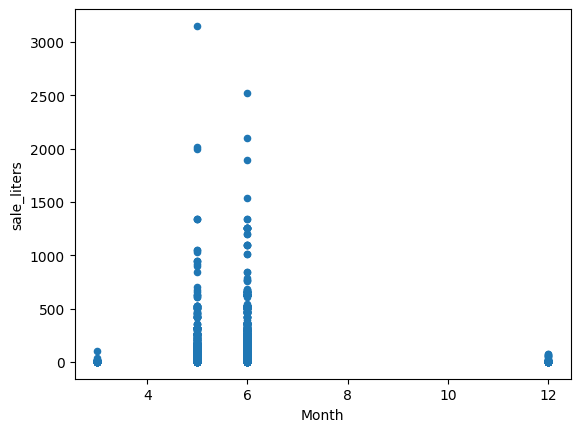

In [143]:
df_liquor.plot.scatter(x="Month", y="sale_liters")

<Axes: xlabel='Size', ylabel='sale_liters'>

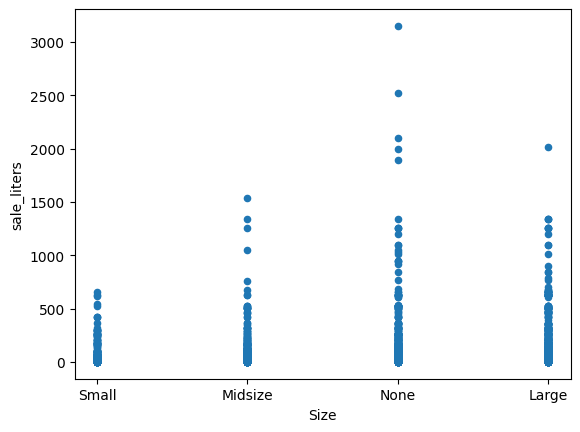

In [144]:
df_liquor.plot.scatter(x="Size", y="sale_liters") # Size of college

<Axes: xlabel='sale_dollars', ylabel='sale_liters'>

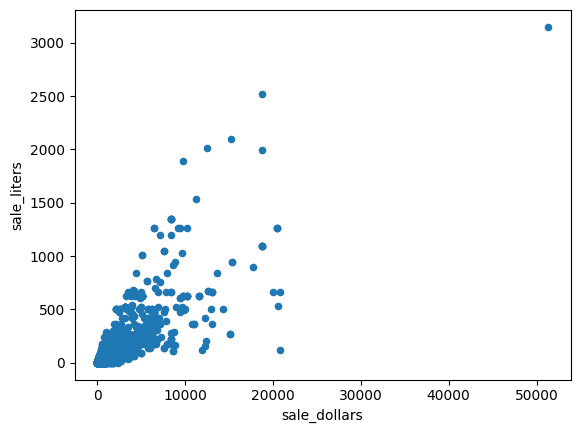

In [145]:
df_liquor.plot.scatter(x="sale_dollars", y="sale_liters")

<Axes: xlabel='CostPerLiter_ln', ylabel='sale_liters'>

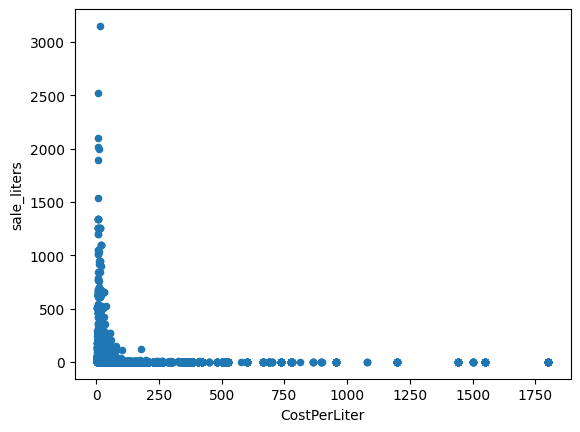

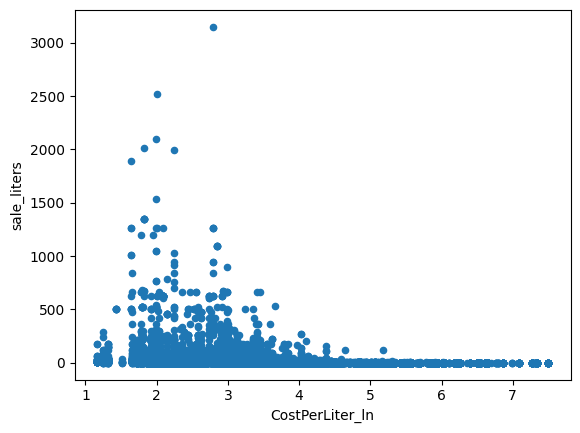

In [146]:
df_liquor.plot.scatter(x="CostPerLiter", y="sale_liters")
df_liquor["CostPerLiter_ln"] = np.log(df_liquor["CostPerLiter"])
df_liquor.plot.scatter(x="CostPerLiter_ln", y="sale_liters")

### Model 3 ("Month", "Size", "Category", "NearHoliday", "Institution", "DayOfWeek", "County")

In [151]:
df_m3 = df_liquor[["sale_liters", "Month", "Size", "Category", "NearHoliday", "Institution", "DayOfWeek", "County"]]
df_m3 = pd.get_dummies(df_m3, columns=["Month", "Category", "Institution", "DayOfWeek", "County", "Size"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m3, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.006436,1441.690045,8.182435
2,0.006440,1441.684839,8.181802
3,0.006443,1441.679774,8.181180
4,0.006447,1441.674843,8.180571
5,0.006451,1441.670039,8.179971
10,0.006468,1441.647738,8.177141
100,0.006595,1441.478604,8.145308
1000,0.006300,1441.898752,8.059024


In [152]:
X = df_m3.drop(["sale_liters"], axis=1)
Y = df_m3["sale_liters"]
X_np = X.to_numpy()
Y_np = Y.to_numpy()

B = ridge(X_np, Y_np, 100, True)
compare_B(B, X)

,B
County_CLINTON,7.139203
County_POCAHONTAS,5.752851
County_DALLAS,4.973364
County_KOSSUTH,4.655708
Category_VODKA,4.009514
...,...
County_VAN BUREN,-4.050214
County_BUTLER,-4.148456
County_MONONA,-5.134473
County_HARRISON,-5.183734


### Model 4 ("Month", "Size", "Category", "NearHoliday", "Institution", "DayOfWeek")

In [153]:
df_m4 = df_liquor[["sale_liters", "Month", "Size", "Category", "NearHoliday", "Institution", "DayOfWeek"]]
df_m4 = pd.get_dummies(df_m4, columns=["Month", "Category", "Institution", "DayOfWeek", "Size"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m4, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.005076,1443.639799,8.096820
2,0.005076,1443.639587,8.096755
3,0.005077,1443.639384,8.096691
4,0.005077,1443.639190,8.096629
5,0.005077,1443.639001,8.096567
10,0.005078,1443.638111,8.096259
100,0.005086,1443.625993,8.090813
1000,0.005087,1443.624394,8.044913


In [154]:
X = df_m4.drop(["sale_liters"], axis=1)
Y = df_m4["sale_liters"]
X_np = X.to_numpy()
Y_np = Y.to_numpy()

B = ridge(X_np, Y_np, 100, True)
compare_B(B, X)

,B
Category_VODKA,4.037746
intercept,3.683619
Category_RUM,3.530834
DayOfWeek_1,2.851219
DayOfWeek_3,1.981293
Institution_5.0,1.821375
Size_Large,1.820163
Institution_4.0,1.638937
NearHoliday,1.633521
Month_5,1.535118


### Model 5 ("Month", "Size", "Category", "NearHoliday", "Institution")

In [155]:
df_m4 = df_liquor[["sale_liters", "Month", "Size", "Category", "NearHoliday", "Institution"]]
df_m4 = pd.get_dummies(df_m4, columns=["Month", "Category", "Institution", "Size"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m4, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.004163,1444.913729,8.052948
2,0.004163,1444.913607,8.052891
3,0.004163,1444.913488,8.052834
4,0.004163,1444.913371,8.052777
5,0.004164,1444.913255,8.052720
10,0.004164,1444.912704,8.052436
100,0.004169,1444.906036,8.047544
1000,0.004158,1444.925782,8.008171


In [156]:
X = df_m4.drop(["sale_liters"], axis=1)
Y = df_m4["sale_liters"]
X_np = X.to_numpy()
Y_np = Y.to_numpy()

B = ridge(X_np, Y_np, 100, True)
compare_B(B, X)

,B
Category_VODKA,4.001389
intercept,3.606549
Category_RUM,3.479972
NearHoliday,2.861053
Size_Large,2.156428
Institution_5.0,1.899135
Month_3,1.615259
Month_5,1.202441
Institution_4.0,1.151376
Institution_2.0,1.042274


### Model 6 ("Month", "Size", "Category", "NearHoliday", "Store")

<Axes: xlabel='Store', ylabel='sale_liters'>

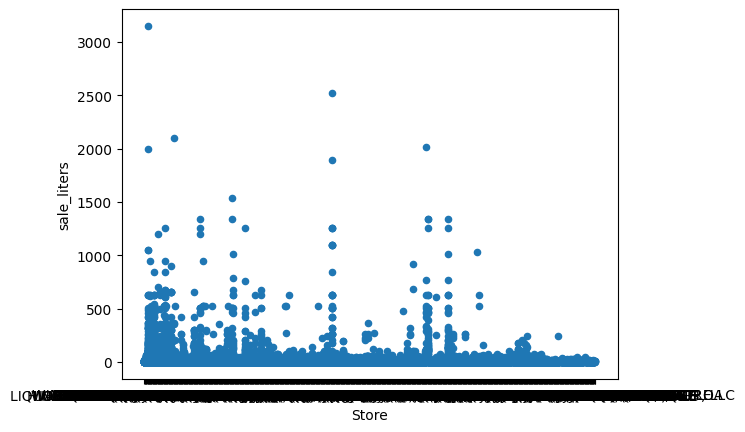

In [157]:
# Reduce amount of dummy vars by grouping Stores
df_liquor["Store"] = df_liquor["StoreName"].str.split("/").apply(lambda x: x[0].split("#")[0])
df_liquor.plot.scatter(x="Store", y="sale_liters")

In [158]:
df_m6 = df_liquor[["sale_liters", "Month", "Size", "Category", "NearHoliday", "Store"]]
df_m6 = pd.get_dummies(df_m6, columns=["Month", "Category", "Size", "Store"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m6, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.082341,1333.122338,7.760372
2,0.082551,1332.843108,7.749733
3,0.082700,1332.653506,7.740524
4,0.082804,1332.527037,7.732380
5,0.082872,1332.451378,7.725126
10,0.082815,1332.628230,7.697747
100,0.064328,1359.588263,7.639411
1000,0.022330,1419.410554,7.765914


In [159]:
X = df_m6.drop(["sale_liters"], axis=1)
Y = df_m6["sale_liters"]
X_np = X.to_numpy()
Y_np = Y.to_numpy()

B = ridge(X_np, Y_np, 5, True)
compare_B(B, X)

,B
Store_COSTCO WHOLESALE,146.693418
Store_SAM'S CLUB 6344,119.558320
Store_SAM'S CLUB 6979,100.562392
Store_SAM'S CLUB 6568,96.624474
Store_SAM'S CLUB 6472,91.306917
...,...
Store_SUPER QUICK,-6.886866
Store_SUPER QUICK 2,-6.932411
Store_QUIK TRIP,-7.679749
Store_MT VERNON DISCOUNT MARKET LLC,-7.908867


### Model 7 (predicting sum of sale_liters per city; Category, Size, NearHoliday)

In [160]:
df_m7 = df_liquor[["sale_liters", "Category", "Size", "NearHoliday", "City"]]
city_sum = df_m7.groupby("City")["sale_liters"].sum()
df_m7["sale_liters_city"] = df_m7.apply(lambda row: city_sum[row["City"]], axis=1)
df_m7 = df_m7.drop(["sale_liters", "City"], axis=1)
df_m7 = pd.get_dummies(df_m7, columns=["Category", "Size"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m7, "sale_liters_city", l_lst, True, [1, 2, 3], 5)

<ipython-input-160-18839090f663>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m7["sale_liters_city"] = df_m7.apply(lambda row: city_sum[row["City"]], axis=1)


,r_sqr,MSE,MAE
lambda,,,
1,0.615795,3.032822e+08,11780.930711
2,0.615795,3.032822e+08,11780.953680
3,0.615796,3.032821e+08,11780.976662
4,0.615796,3.032821e+08,11780.999659
5,0.615796,3.032821e+08,11781.022669
10,0.615796,3.032821e+08,11781.138481
100,0.615779,3.032953e+08,11783.399671
1000,0.614181,3.045605e+08,11830.141766


In [161]:
X = df_m7.drop(["sale_liters_city"], axis=1)
Y = df_m7["sale_liters_city"]
X_np = X.to_numpy()
Y_np = Y.to_numpy()

B = ridge(X_np, Y_np, 1, True)
compare_B(B, X)

,B
Size_Large,38146.419581
intercept,17895.242068
Category_BRANDY,5440.936314
Category_TEQUILA,4572.721080
Size_Midsize,2060.267928
Category_GIN,1997.966539
Category_VODKA,1747.366128
Category_OTHER,1242.067799
Category_RUM,981.102949
Category_SCHNAPPS,945.627917


### Model 8 (predicting sum of sale_liters per city; Category, Size, NearHoliday, Institution)

In [162]:
df_m8 = df_liquor[["sale_liters", "Category", "Size", "NearHoliday", "City", "Institution"]]
city_sum = df_m8.groupby("City")["sale_liters"].sum()
df_m8["sale_liters_city"] = df_m8.apply(lambda row: city_sum[row["City"]], axis=1)
df_m8 = df_m8.drop(["sale_liters", "City"], axis=1)
df_m8 = pd.get_dummies(df_m8, columns=["Category", "Size", "Institution"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m8, "sale_liters_city", l_lst, True, [1, 2, 3], 5)

<ipython-input-162-35b604f18ded>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m8["sale_liters_city"] = df_m8.apply(lambda row: city_sum[row["City"]], axis=1)


,r_sqr,MSE,MAE
lambda,,,
1,0.776418,1.764931e+08,8453.022603
2,0.776418,1.764931e+08,8453.117615
3,0.776418,1.764931e+08,8453.223832
4,0.776418,1.764932e+08,8453.339182
5,0.776418,1.764932e+08,8453.454550
10,0.776418,1.764938e+08,8454.031546
100,0.776327,1.765654e+08,8468.464028
1000,0.771230,1.805911e+08,8892.558134


In [163]:
X = df_m8.drop(["sale_liters_city"], axis=1)
Y = df_m8["sale_liters_city"]
X_np = X.to_numpy()
Y_np = Y.to_numpy()

B = ridge(X_np, Y_np, 1, True)
compare_B(B, X)

,B
Institution_4.0,34008.717352
Institution_3.0,25558.272384
intercept,20036.943572
Size_Large,15377.629886
Size_Midsize,11391.101502
Category_TEQUILA,3931.919081
Category_BRANDY,3278.701897
Category_GIN,3269.845128
Category_VODKA,2128.526065
Category_OTHER,1989.147094


In [164]:
df_m8 = df_liquor[["sale_liters", "Category", "Size", "NearHoliday", "City", "Institution"]]
city_sum = df_m8.groupby("City")["sale_liters"].sum()
df_m8["sale_liters_city"] = df_m8.apply(lambda row: city_sum[row["City"]], axis=1)
df_m8 = df_m8.drop(["sale_liters", "City"], axis=1)
df_m8 = pd.get_dummies(df_m8, columns=["Category", "Size"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m8, "sale_liters_city", l_lst, True, [1, 2, 3], 5)

<ipython-input-164-f76a9ed5d377>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m8["sale_liters_city"] = df_m8.apply(lambda row: city_sum[row["City"]], axis=1)


,r_sqr,MSE,MAE
lambda,,,
1,0.720436,2.206700e+08,10547.462121
2,0.720436,2.206700e+08,10547.385402
3,0.720436,2.206700e+08,10547.308705
4,0.720436,2.206700e+08,10547.232029
5,0.720436,2.206700e+08,10547.155375
10,0.720436,2.206699e+08,10546.772433
100,0.720430,2.206748e+08,10539.990129
1000,0.719857,2.211263e+08,10486.902706


In [165]:
X = df_m8.drop(["sale_liters_city"], axis=1)
Y = df_m8["sale_liters_city"]
X_np = X.to_numpy()
Y_np = Y.to_numpy()

B = ridge(X_np, Y_np, 1, True)
compare_B(B, X)

,B
Size_Large,18156.655429
Institution,10945.860791
intercept,6127.651172
Category_TEQUILA,2683.372614
Category_BRANDY,2290.025530
Size_None,1785.799851
Category_GIN,1456.817928
Category_VODKA,507.392335
Category_OTHER,269.794390
Category_RUM,-143.861150


### Model 9 (predicting sum of sale_liters per city; Category, NearHoliday, Institution)

In [166]:
df_m9 = df_liquor[["sale_liters", "Category", "NearHoliday", "City", "Institution"]]
city_sum = df_m9.groupby("City")["sale_liters"].sum()
df_m9["sale_liters_city"] = df_m9.apply(lambda row: city_sum[row["City"]], axis=1)
df_m9 = df_m9.drop(["sale_liters", "City"], axis=1)
df_m9 = pd.get_dummies(df_m9, columns=["Category", "Institution"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m9, "sale_liters_city", l_lst, True, [1, 2, 3], 5)

<ipython-input-166-c14267e542cc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m9["sale_liters_city"] = df_m9.apply(lambda row: city_sum[row["City"]], axis=1)


,r_sqr,MSE,MAE
lambda,,,
1,0.764471,1.859237e+08,9192.949598
2,0.764471,1.859237e+08,9193.307264
3,0.764471,1.859238e+08,9193.664875
4,0.764471,1.859238e+08,9194.022442
5,0.764471,1.859238e+08,9194.379997
10,0.764470,1.859243e+08,9196.166782
100,0.764400,1.859803e+08,9229.627964
1000,0.758812,1.903949e+08,9720.462318


In [167]:
X = df_m9.drop(["sale_liters_city"], axis=1)
Y = df_m9["sale_liters_city"]
X_np = X.to_numpy()
Y_np = Y.to_numpy()

B = ridge(X_np, Y_np, 1, True)
compare_B(B, X)

,B
Institution_4.0,41290.451492
Institution_3.0,32854.725759
intercept,27542.009252
Category_TEQUILA,4796.352299
Category_GIN,4282.787980
Category_BRANDY,4026.950591
Category_VODKA,3024.769435
Category_OTHER,2816.285215
Category_RUM,2407.191344
Category_WHISKY,2364.801303
